## More different-er time series

*Alex I. Malz (LINCC Frameworks@CMU), Matthew Graham (Caltech)*

This notebook is for the topological data analysis (TDA) project as part of the Time-Domain Needles in Rubin's Haystack hackathon (April 17-19 2024, CfA).

The first idea is to create a distance matrix from the persistence diagrams of a set of time series and then learn a manifold from this and then identify outliers relative to the manifold.

We'll use the scikit-tda package to create persistence diagrams of 1D time series using a watershed (lower star or sublevelset filtration).

In [3]:
!pip install ripser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18101 sha256=cdde96caff455f44f0d6e0f0894b5384b0d3d081b2905c3d7c711e63b29bc045
  Stored in directory: /root/.cache/pip/wheels/ef/0f/3b/0f931844eecc34addd90e72d54cd39c08b7066c5f25c00b9a4
Successfully built hopcroftkarp


In [4]:
# %matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import sparse

from ripser import ripser
import persim as ps

### Basics

Let's start with a simulated irregularly sampled time series - we'll use a lognormal distribution for the dts:

In [5]:
def genSimTS(mu, sigma, npts, func, pars):
    # mu, sigma, npts = mu, sigma, npts
    dt = np.random.lognormal(mu, sigma, npts)
    t = np.cumsum(dt)
    y = func(t, *pars)
    return np.array([t, y])

In [6]:
npts = 500

In [7]:
f_cos = lambda x, per: np.cos(2. * np.pi * x / per)

ts1 = genSimTS(np.log(5), 0.5, npts, f_cos, [0.4])
ts2 = genSimTS(np.log(5), 0.5, npts, f_cos, [0.4])

In [8]:
# fig, ax = plt.subplots()
# count, bins, _ = ax.hist(dt, 100, density = True, align = 'mid')
# plt.show()

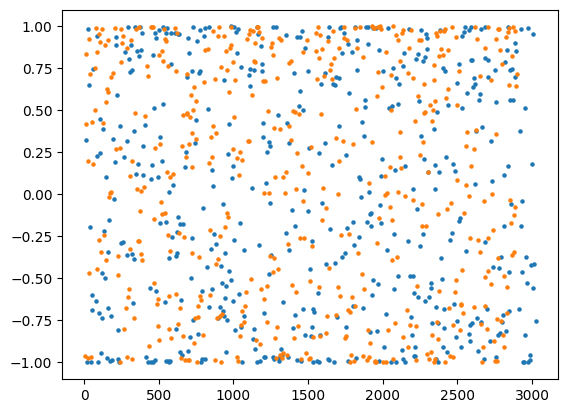

In [14]:
# fig, ax = plt.subplots(2, 1)
plt.scatter(ts1[0], ts1[1], s=5, label='first instantiation')
plt.scatter(ts2[0], ts2[1], s=5, label='second instantiation')
# plt.legend()

Let's construct the persistence diagram for the time series:
Q. Does this only work for regularly sampled time series?

In [32]:
def getPD(ts):
    t, y = ts
    npts = len(t)

    # Add edges between adjacent points in the time series
    I = np.arange(npts - 1)
    J = np.arange(1, npts)
    V = np.maximum(y[0: -1], y[1::])

    # Add vertex birth times along the diagonal of the distance matrix
    I = np.concatenate((I, np.arange(npts)))
    J = np.concatenate((J, np.arange(npts)))
    V = np.concatenate((V, y))

    # Create a sparse distance matrix representation
    D = sparse.coo_matrix((V, (I, J)), shape = (npts, npts)).tocsr()
    dgm0 = ripser(D, maxdim = 0, distance_matrix = True)['dgms'][0]
    dgm0 = dgm0[dgm0[:, 1] - dgm0[:, 0] > 1e-3, :]
    return dgm0

and plot it:

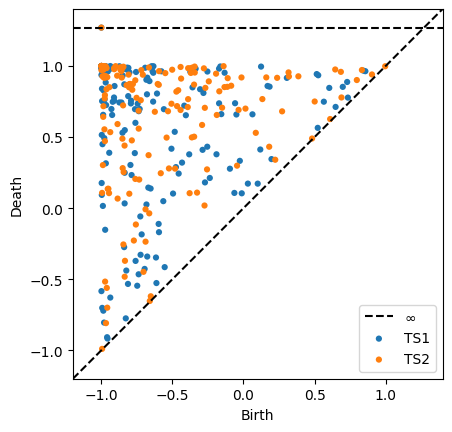

In [18]:
dgm1 = getPD(ts1)
dgm2 = getPD(ts2)

fig, ax = plt.subplots()
ps.plot_diagrams([dgm1, dgm2], labels = ['TS1', 'TS2'], show = True)

Chen et al. (2021) provide fast (O(n)) approximation algorithms for the 1-Wasserstein distance between PDs. Alternatively, we can use the various distances defined in the persim package: Wasserstein, Bottleneck, Sliced Wasserstein, and continuous heat kernel.
(But does the bottleneck distance requires that there are equal numbers of points in the two PDs?)

In [17]:
dgm1, dgm2 = dgm1[:-1], dgm2[:-1]

print(f"Wasserstein: {ps.wasserstein(dgm1[:-1], dgm2)}")
print(f"Bottleneck: {ps.bottleneck(dgm1, dgm2)}")
print(f"Sliced Wasserstein: {ps.sliced_wasserstein(dgm1, dgm2, M = 50)}")
print(f"Heat: {ps.heat(dgm1, dgm2)}")

Wasserstein: 15.740239449618079
Bottleneck: 0.2450365126132965
Sliced Wasserstein: 13.955372426444939
Heat: 1.7532265369680402


## Multiple classes: do their persistence diagrams look different?

Let's visually compare these for different functional time-series but same sampling distribution.

In [58]:
def generate_trand_and_plot_pd(mu, sigma, npts, f1, f2, pars1, pars2):
  ts1 = genSimTS(mu, sigma, npts, f1, pars1)
  ts2 = genSimTS(mu, sigma, npts, f2, pars2)

  fig, ax = plt.subplots(1, 2)
  ax[0].scatter(ts1[0], ts1[1], s=5)
  ax[0].scatter(ts2[0], ts2[1], s=5)

  dgm1 = getPD(ts1).T
  dgm2 = getPD(ts2).T
  ax[1].scatter(dgm1[0], dgm1[1], s=5)
  ax[1].scatter(dgm2[0], dgm2[1], s=5)
  ax[1].set_xlim(-1, 1)
  ax[1].set_ylim(-1, 1)

Is the PD sensitive to phase?

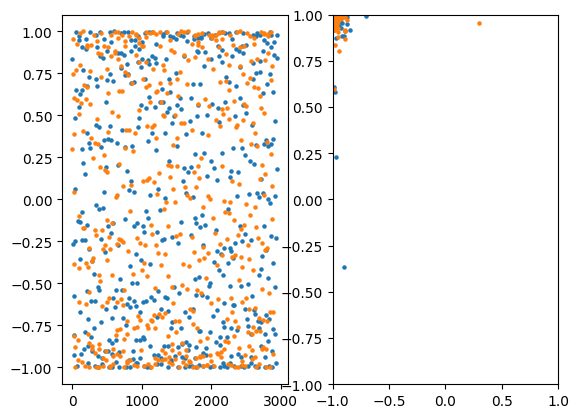

In [61]:
f_sin = lambda x, per: np.sin(2. * np.pi * x / per)

generate_trand_and_plot_pd(np.log(5), 0.5, 500, f_cos, f_sin, [50.], [50.])

## Sampling regularity/density: does this dominate the persistence diagram?



In [37]:
def gengenSimTS(t, func, pars):
    y = func(t, *pars)
    return np.array([t, y])

In [51]:
def generate_and_plot_pd(t1, t2, f1, f2, pars1, pars2):
  ts1 = gengenSimTS(t1, f1, pars1)
  ts2 = gengenSimTS(t2, f2, pars2)

  fig, ax = plt.subplots(1, 2)
  ax[0].scatter(ts1[0], ts1[1], s=5)
  ax[0].scatter(ts2[0], ts2[1], s=5)

  dgm1 = getPD(ts1).T
  dgm2 = getPD(ts2).T
  ax[1].scatter(dgm1[0], dgm1[1], s=5)
  ax[1].scatter(dgm2[0], dgm2[1], s=5)
  ax[1].set_xlim(-1, 1)
  ax[1].set_ylim(-1, 1)

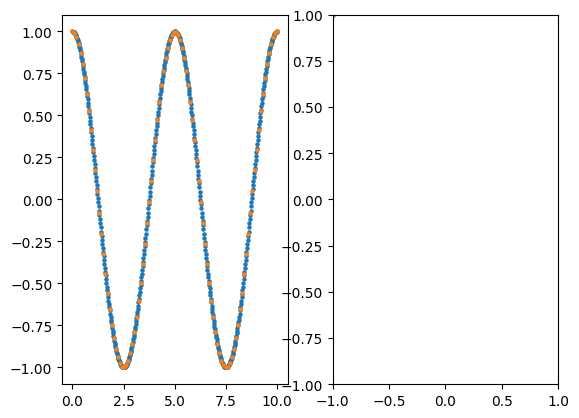

In [56]:
t1 = np.linspace(0,10,500)
t2 = np.linspace(0,10,100)

generate_and_plot_pd(t1, t2, f_cos, f_cos, [5], [5])

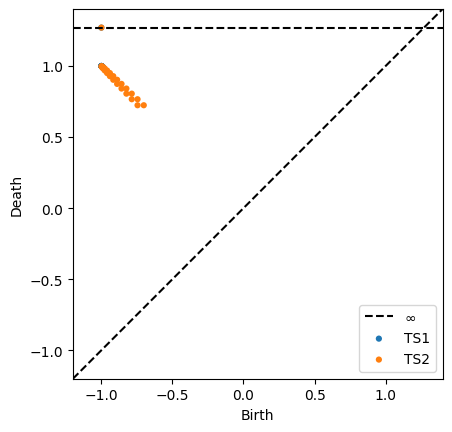

In [55]:
dgm1 = getPD(gengenSimTS(t1, f_cos, [0.4]))
dgm2 = getPD(gengenSimTS(t2, f_cos, [0.4]))

fig, ax = plt.subplots()
ps.plot_diagrams([dgm1, dgm2], labels = ['TS1', 'TS2'], show = True)

### A set of time series